In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from sklearn.utils import shuffle

C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# 把所有年份的資料merge在一起,並存在data.csv裡
def mergeData():
    SaveFile_Name = 'data.csv'
    file_list = os.listdir('data')
    df = pd.read_csv('data'+'\\'+file_list[0])
    df.to_csv(SaveFile_Name,encoding="utf_8_sig",index=False)
    for i in range(1,len(file_list)):
        df = pd.read_csv('data'+'\\'+file_list[i])
        df.to_csv(SaveFile_Name,encoding="utf_8_sig",index=False, header=False, mode='a+')

In [3]:
# 讀取data.csv
def readData():
    train = pd.read_csv("data.csv")
    return train

In [4]:
# 把年份換成西元年
def changeYear(data):
    for i in range(0,data.shape[0]):
        Date=data["日期"][i].split('/')
        year,month,date=Date[0],Date[1],Date[2]
        year=str(int(year)+1911)
        data.loc[i,"日期"]=year+'/'+month+'/'+date
    return data

In [5]:
# 增加features("年","月","日","第幾日")
def augFeatures(data):
  data["日期"] = pd.to_datetime(data["日期"])
  data["年"] = data["日期"].dt.year
  data["月"] = data["日期"].dt.month
  data["日"] = data["日期"].dt.day
  data["第幾日"] = data["日期"].dt.dayofweek
  return data

In [6]:
# 把非數字的資料換成正確資料,並減少features("日期","成交股數","成交金額",等等...)
def manage(data):
    for i in range(0,data.shape[0]):
        if data["漲跌價差"][i]=='X0.00':
            data.loc[i,"漲跌價差"]=str(int(data["收盤價"][i])-int(data["收盤價"][i-1]))
    data=data.drop(["日期"], axis=1)
    data=data.drop(["成交股數"], axis=1)
    data=data.drop(["成交金額"], axis=1)
    data=data.drop(["漲跌價差"], axis=1)
    data=data.drop(["成交筆數"], axis=1)
    data=data.convert_objects(convert_numeric=True)
    return data

In [7]:
# 把資料normalize
def normalize(train):
    train = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train

In [8]:
# 創造出train的資料,train_x為輸入資料(所有features),train_y為輸出資料(開盤價的成長率,分為9個區段)
def buildTrain(train, pastDay=3, futureDay=1):
    X_train, Y_train, Z_train= [], [], []
    X,Y,Z=[],[],[]
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["開盤價"]))
        Z_train.append(np.array(train.iloc[i+pastDay-1:i+pastDay]["開盤價"]))
    X=np.array(X_train)
    Y=np.array(Y_train)
    Z=np.array(Z_train)
    Y=100*((Y-Z)/Z)
    Y_train=[]
    
    for i in range(len(Y)):
        if Y[i]<-3.5:
            Y_train.append(np.array([0]))
        elif -3.5<=Y[i]<-2.5:
            Y_train.append(np.array([1]))
        elif -2.5<=Y[i]<-1.5:
            Y_train.append(np.array([2]))
        elif -1.5<=Y[i]<-0.5:
            Y_train.append(np.array([3]))
        elif -0.5<=Y[i]<0.5:
            Y_train.append(np.array([4]))
        elif 0.5<=Y[i]<1.5:
            Y_train.append(np.array([5]))
        elif 1.5<=Y[i]<2.5:
            Y_train.append(np.array([6]))
        elif 2.5<=Y[i]<3.5:
            Y_train.append(np.array([7]))
        elif 3.5<=Y[i]:
            Y_train.append(np.array([8]))
    Y=np.array(Y_train)
    
    return X, Y

In [9]:
# 把資料打亂
def shuffle(X,Y):
    np.random.seed()
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]

In [10]:
# 將資料分成訓練資料和測試資料
def splitData(X,Y,rate):
    X_train = X[:-int(X.shape[0]*rate)]

    Y_train = Y[:-int(Y.shape[0]*rate)]
    
    X_val = X[-int(X.shape[0]*rate):]

    Y_val = Y[-int(Y.shape[0]*rate):]
    return X_train, Y_train, X_val, Y_val

In [11]:
# 建立模型
def buildModel(shape):
    model = Sequential()
    model.add(LSTM(250, input_shape=(shape[1],shape[2]),return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(150,return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(100))
    model.add(Dropout(0.5))
    model.add(Dense(9)) 
    model.add(Activation('softmax'))
    model.compile(loss="categorical_crossentropy", optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

In [12]:
import matplotlib.pyplot as plt
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
 
    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))
 
    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))
 
    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()


In [64]:
mergeData()
train=readData()
train=changeYear(train)
train=augFeatures(train)
train=manage(train)
train=train.drop(["最高價"], axis=1)
train=train.drop(["最低價"], axis=1)
train=train.drop(["收盤價"], axis=1)
train=train.drop(["年"], axis=1)
train=train.drop(["月"], axis=1)
train=train.drop(["日"], axis=1)
train=train.drop(["第幾日"], axis=1)
temp=train
train=normalize(train)
train_x1, train_y1 = buildTrain(train,3,1)
train_x2, train_y2 = buildTrain(temp,3,1)
train_x, train_y = train_x1,train_y2 
train_y=np_utils.to_categorical(train_y)
train_x, train_y = shuffle(train_x, train_y )
train_x, train_y , test_x, test_y = splitData(train_x, train_y , 0.1)
history = LossHistory()
model = buildModel(train_x.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(train_x, train_y, epochs=300, batch_size=128, verbose=2,validation_split=0.1, callbacks=[callback,history])


C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  after removing the cwd from sys.path.
C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, return_sequences=True, input_shape=(1, 1))`
  after removing the cwd from sys.path.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 1, 200)            161600    
_________________________________________________________________
dropout_27 (Dropout)         (None, 1, 200)            0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dropout_28 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 9)                 1809      
_________________________________________________________________
activation_24 (Activation)   (None, 9)                 0         
Total params: 484,209
Trainable params: 484,209
Non-trainable params: 0
_________________________________________________________________
Trai

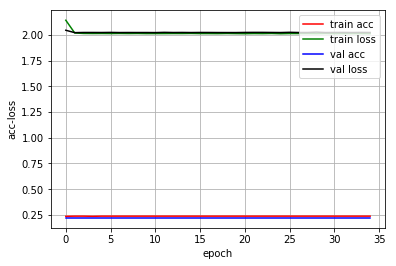

618/618 [==============================] - 0s 142us/step
test loss:  2.01013220783962
test accuracy:  0.27022653740972374


In [65]:
history.loss_plot('epoch')
loss_1, accuracy_1 = model.evaluate(test_x, test_y)
print('test loss: ', loss_1)
print('test accuracy: ', accuracy_1)

In [66]:
mergeData()
train=readData()
train=changeYear(train)
train=augFeatures(train)
train=manage(train)
train=train.drop(["最高價"], axis=1)
train=train.drop(["最低價"], axis=1)
train=train.drop(["收盤價"], axis=1)
temp=train
train=normalize(train)
train_x1, train_y1 = buildTrain(train,3,1)
train_x2, train_y2 = buildTrain(temp,3,1)
train_x, train_y = train_x1,train_y2 
train_y=np_utils.to_categorical(train_y)
train_x, train_y = shuffle(train_x, train_y )
train_x, train_y , test_x, test_y = splitData(train_x, train_y , 0.1)
history = LossHistory()
model = buildModel(train_x.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(train_x, train_y, epochs=300, batch_size=128, verbose=2,validation_split=0.1, callbacks=[callback,history])


C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  after removing the cwd from sys.path.
C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, return_sequences=True, input_shape=(1, 5))`
  after removing the cwd from sys.path.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 1, 200)            164800    
_________________________________________________________________
dropout_29 (Dropout)         (None, 1, 200)            0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dropout_30 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 9)                 1809      
_________________________________________________________________
activation_25 (Activation)   (None, 9)                 0         
Total params: 487,409
Trainable params: 487,409
Non-trainable params: 0
_________________________________________________________________
Trai

Epoch 84/300
 - 1s - loss: 1.9483 - acc: 0.2460 - val_loss: 2.0016 - val_acc: 0.2455
Epoch 85/300
 - 1s - loss: 1.9503 - acc: 0.2498 - val_loss: 1.9997 - val_acc: 0.2401
Epoch 86/300
 - 1s - loss: 1.9494 - acc: 0.2478 - val_loss: 2.0018 - val_acc: 0.2401
Epoch 87/300
 - 1s - loss: 1.9484 - acc: 0.2500 - val_loss: 2.0011 - val_acc: 0.2401
Epoch 88/300
 - 1s - loss: 1.9491 - acc: 0.2484 - val_loss: 2.0010 - val_acc: 0.2401
Epoch 89/300
 - 1s - loss: 1.9483 - acc: 0.2494 - val_loss: 2.0029 - val_acc: 0.2401
Epoch 90/300
 - 1s - loss: 1.9490 - acc: 0.2486 - val_loss: 2.0030 - val_acc: 0.2419
Epoch 91/300
 - 1s - loss: 1.9483 - acc: 0.2490 - val_loss: 1.9995 - val_acc: 0.2384
Epoch 92/300
 - 1s - loss: 1.9494 - acc: 0.2507 - val_loss: 2.0003 - val_acc: 0.2366
Epoch 93/300
 - 1s - loss: 1.9464 - acc: 0.2490 - val_loss: 2.0001 - val_acc: 0.2384
Epoch 94/300
 - 1s - loss: 1.9481 - acc: 0.2488 - val_loss: 2.0004 - val_acc: 0.2384
Epoch 95/300
 - 1s - loss: 1.9499 - acc: 0.2513 - val_loss: 1.999

Epoch 180/300
 - 1s - loss: 1.9199 - acc: 0.2657 - val_loss: 1.9890 - val_acc: 0.2455
Epoch 181/300
 - 1s - loss: 1.9205 - acc: 0.2625 - val_loss: 1.9889 - val_acc: 0.2419
Epoch 182/300
 - 1s - loss: 1.9219 - acc: 0.2605 - val_loss: 1.9901 - val_acc: 0.2419
Epoch 183/300
 - 1s - loss: 1.9170 - acc: 0.2617 - val_loss: 1.9910 - val_acc: 0.2401
Epoch 184/300
 - 1s - loss: 1.9207 - acc: 0.2579 - val_loss: 1.9904 - val_acc: 0.2437
Epoch 185/300
 - 1s - loss: 1.9179 - acc: 0.2641 - val_loss: 1.9899 - val_acc: 0.2419
Epoch 186/300
 - 1s - loss: 1.9185 - acc: 0.2675 - val_loss: 1.9903 - val_acc: 0.2419
Epoch 187/300
 - 1s - loss: 1.9180 - acc: 0.2613 - val_loss: 1.9927 - val_acc: 0.2473
Epoch 188/300
 - 1s - loss: 1.9176 - acc: 0.2633 - val_loss: 1.9902 - val_acc: 0.2437
Epoch 189/300
 - 1s - loss: 1.9164 - acc: 0.2601 - val_loss: 1.9913 - val_acc: 0.2419
Epoch 190/300
 - 1s - loss: 1.9175 - acc: 0.2637 - val_loss: 1.9900 - val_acc: 0.2294
Epoch 191/300
 - 1s - loss: 1.9192 - acc: 0.2649 - val

Epoch 276/300
 - 1s - loss: 1.8841 - acc: 0.2769 - val_loss: 1.9959 - val_acc: 0.2330
Epoch 277/300
 - 1s - loss: 1.8863 - acc: 0.2697 - val_loss: 1.9972 - val_acc: 0.2330
Epoch 278/300
 - 1s - loss: 1.8843 - acc: 0.2745 - val_loss: 2.0000 - val_acc: 0.2348
Epoch 279/300
 - 1s - loss: 1.8837 - acc: 0.2777 - val_loss: 1.9987 - val_acc: 0.2312
Epoch 280/300
 - 1s - loss: 1.8821 - acc: 0.2799 - val_loss: 1.9984 - val_acc: 0.2258
Epoch 00280: early stopping


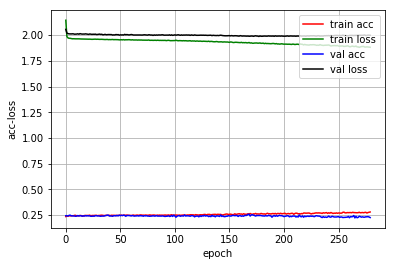

618/618 [==============================] - 0s 154us/step
test loss:  1.9906102013819427
test accuracy:  0.23300970893075937


In [67]:
history.loss_plot('epoch')
loss_2, accuracy_2 = model.evaluate(test_x, test_y)
print('test loss: ', loss_2)
print('test accuracy: ', accuracy_2)

In [68]:
mergeData()
train=readData()
train=changeYear(train)
train=augFeatures(train)
train=manage(train)
train=train.drop(["收盤價"], axis=1)
temp=train
train=normalize(train)
train_x1, train_y1 = buildTrain(train,3,1)
train_x2, train_y2 = buildTrain(temp,3,1)
train_x, train_y = train_x1,train_y2 
train_y=np_utils.to_categorical(train_y)
train_x, train_y = shuffle(train_x, train_y )
train_x, train_y , test_x, test_y = splitData(train_x, train_y , 0.1)
history = LossHistory()
model = buildModel(train_x.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(train_x, train_y, epochs=300, batch_size=128, verbose=2,validation_split=0.1, callbacks=[callback,history])


C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  after removing the cwd from sys.path.
C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, return_sequences=True, input_shape=(1, 7))`
  after removing the cwd from sys.path.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 1, 200)            166400    
_________________________________________________________________
dropout_31 (Dropout)         (None, 1, 200)            0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dropout_32 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 9)                 1809      
_________________________________________________________________
activation_26 (Activation)   (None, 9)                 0         
Total params: 489,009
Trainable params: 489,009
Non-trainable params: 0
_________________________________________________________________
Trai

Epoch 84/300
 - 1s - loss: 1.9511 - acc: 0.2480 - val_loss: 1.9515 - val_acc: 0.2473
Epoch 85/300
 - 1s - loss: 1.9478 - acc: 0.2498 - val_loss: 1.9508 - val_acc: 0.2491
Epoch 86/300
 - 1s - loss: 1.9482 - acc: 0.2500 - val_loss: 1.9497 - val_acc: 0.2455
Epoch 87/300
 - 1s - loss: 1.9476 - acc: 0.2507 - val_loss: 1.9495 - val_acc: 0.2437
Epoch 88/300
 - 1s - loss: 1.9472 - acc: 0.2486 - val_loss: 1.9530 - val_acc: 0.2527
Epoch 89/300
 - 1s - loss: 1.9466 - acc: 0.2527 - val_loss: 1.9504 - val_acc: 0.2527
Epoch 90/300
 - 1s - loss: 1.9456 - acc: 0.2498 - val_loss: 1.9491 - val_acc: 0.2455
Epoch 91/300
 - 1s - loss: 1.9457 - acc: 0.2525 - val_loss: 1.9510 - val_acc: 0.2437
Epoch 92/300
 - 1s - loss: 1.9475 - acc: 0.2511 - val_loss: 1.9495 - val_acc: 0.2473
Epoch 93/300
 - 1s - loss: 1.9451 - acc: 0.2527 - val_loss: 1.9491 - val_acc: 0.2491
Epoch 94/300
 - 1s - loss: 1.9474 - acc: 0.2519 - val_loss: 1.9493 - val_acc: 0.2437
Epoch 95/300
 - 1s - loss: 1.9430 - acc: 0.2515 - val_loss: 1.949

Epoch 180/300
 - 1s - loss: 1.8980 - acc: 0.2733 - val_loss: 1.9288 - val_acc: 0.2545
Epoch 181/300
 - 1s - loss: 1.8953 - acc: 0.2723 - val_loss: 1.9303 - val_acc: 0.2616
Epoch 182/300
 - 1s - loss: 1.8987 - acc: 0.2691 - val_loss: 1.9328 - val_acc: 0.2437
Epoch 183/300
 - 1s - loss: 1.8917 - acc: 0.2791 - val_loss: 1.9226 - val_acc: 0.2527
Epoch 184/300
 - 1s - loss: 1.8912 - acc: 0.2779 - val_loss: 1.9177 - val_acc: 0.2581
Epoch 185/300
 - 1s - loss: 1.8919 - acc: 0.2819 - val_loss: 1.9208 - val_acc: 0.2527
Epoch 186/300
 - 1s - loss: 1.8933 - acc: 0.2779 - val_loss: 1.9208 - val_acc: 0.2491
Epoch 187/300
 - 1s - loss: 1.8889 - acc: 0.2833 - val_loss: 1.9173 - val_acc: 0.2527
Epoch 188/300
 - 1s - loss: 1.8851 - acc: 0.2755 - val_loss: 1.9225 - val_acc: 0.2634
Epoch 189/300
 - 1s - loss: 1.8909 - acc: 0.2775 - val_loss: 1.9161 - val_acc: 0.2527
Epoch 190/300
 - 1s - loss: 1.8850 - acc: 0.2845 - val_loss: 1.9189 - val_acc: 0.2563
Epoch 191/300
 - 1s - loss: 1.8850 - acc: 0.2803 - val

Epoch 276/300
 - 1s - loss: 1.6905 - acc: 0.3399 - val_loss: 1.7570 - val_acc: 0.3065
Epoch 277/300
 - 1s - loss: 1.7019 - acc: 0.3395 - val_loss: 1.7049 - val_acc: 0.3333
Epoch 278/300
 - 1s - loss: 1.6810 - acc: 0.3491 - val_loss: 1.7110 - val_acc: 0.3333
Epoch 279/300
 - 1s - loss: 1.6926 - acc: 0.3421 - val_loss: 1.7020 - val_acc: 0.3244
Epoch 280/300
 - 1s - loss: 1.6761 - acc: 0.3505 - val_loss: 1.6999 - val_acc: 0.3315
Epoch 281/300
 - 1s - loss: 1.6758 - acc: 0.3519 - val_loss: 1.7045 - val_acc: 0.3190
Epoch 282/300
 - 1s - loss: 1.6789 - acc: 0.3507 - val_loss: 1.7077 - val_acc: 0.3136
Epoch 283/300
 - 1s - loss: 1.6737 - acc: 0.3581 - val_loss: 1.7080 - val_acc: 0.3333
Epoch 284/300
 - 1s - loss: 1.6676 - acc: 0.3581 - val_loss: 1.6887 - val_acc: 0.3208
Epoch 285/300
 - 1s - loss: 1.6638 - acc: 0.3479 - val_loss: 1.6917 - val_acc: 0.3190
Epoch 286/300
 - 1s - loss: 1.6796 - acc: 0.3445 - val_loss: 1.6941 - val_acc: 0.3315
Epoch 287/300
 - 1s - loss: 1.6784 - acc: 0.3493 - val

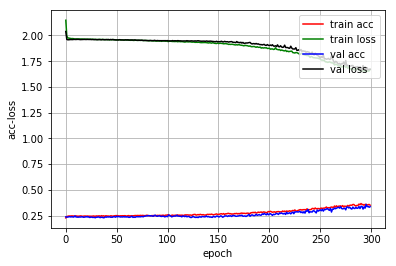

618/618 [==============================] - 0s 146us/step
test loss:  1.7236686331554525
test accuracy:  0.3430420715832016


In [69]:
history.loss_plot('epoch')
loss_3, accuracy_3 = model.evaluate(test_x, test_y)
print('test loss: ', loss_3)
print('test accuracy: ', accuracy_3)

In [ ]:
mergeData()
train=readData()
train=changeYear(train)
train=augFeatures(train)
train=manage(train)
temp=train
train=normalize(train)
train_x1, train_y1 = buildTrain(train,3,1)
train_x2, train_y2 = buildTrain(temp,3,1)
train_x, train_y = train_x1,train_y2 
train_y=np_utils.to_categorical(train_y)
train_x, train_y = shuffle(train_x, train_y )
train_x, train_y , test_x, test_y = splitData(train_x, train_y , 0.1)
history = LossHistory()
model = buildModel(train_x.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(train_x, train_y, epochs=300, batch_size=16, verbose=2,validation_split=0.1, callbacks=[callback,history])



C:\Users\admin\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # This is added back by InteractiveShellApp.init_path()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 3, 250)            259000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 250)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 150)            240600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 150)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               100400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 909       
__________

In [ ]:
history.loss_plot('epoch')
loss_4, accuracy_4 = model.evaluate(test_x, test_y)
print('test loss: ', loss_4)
print('test accuracy: ', accuracy_4)

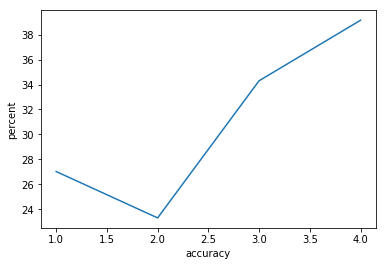

In [70]:
accuracy=[accuracy_1*100,accuracy_2*100,accuracy_3*100,accuracy_4*100]
number=[1,2,3,4]
plt.plot(number, accuracy)
plt.xlabel("accuracy")
plt.ylabel("percent")
plt.show()